In [58]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from matplotlib import cm


In [59]:
labels_path = "/neurospin/dico/rmenasria/Runs/03_main/Input/ABCD/ABCD_preterm_labels_light.csv"
base_path   = "/neurospin/dico/data/deep_folding/current/models/Champollion_V1_after_ablation/embeddings/ABCD_embeddings/"

In [60]:
labels_df = pd.read_csv(labels_path, low_memory=False)
labels_df['src_subject_id'] = labels_df['src_subject_id'].str.replace("_","")

In [61]:
thresholds  = ["<27","27-32","32-37"]
threshold = thresholds[1]
region = "STs_right"
#region = "FCMpost-SpC_right"

In [62]:
embedding_file = None
for file in os.listdir(base_path):
    if file.startswith(region) and file.endswith(".csv"):
        embedding_file = file
        break
if embedding_file is None:
    raise FileNotFoundError(f"No embedding file found for region: {region}")

emb_path = os.path.join(base_path, embedding_file)
emb_df = pd.read_csv(emb_path)
emb_df['ID_clean'] = (
    emb_df['ID'].astype(str)
    .str.replace(r"^sub-", "", regex=True)
    .str.replace("_", "", regex=False)
)

df = emb_df.merge(
    labels_df,
    left_on='ID_clean', right_on='src_subject_id', how='inner'
)
df = df[df['prem_class'].isin([threshold, ">=37"])].copy()
df['y'] = (df['prem_class'] == threshold).astype(int)
X = df.filter(regex=r'^dim').values
y = df[['src_subject_id','y']]

In [63]:
# Ensure the labels and embeddings are aligned by printing the first few rows
print("First few rows of the merged DataFrame:")
print(df[['ID_clean', 'src_subject_id','prem_class', 'y']].head())



First few rows of the merged DataFrame:
          ID_clean   src_subject_id prem_class  y
0  NDARINV003RTV85  NDARINV003RTV85       >=37  0
1  NDARINV007W6H7B  NDARINV007W6H7B       >=37  0
2  NDARINV00BD7VDC  NDARINV00BD7VDC       >=37  0
3  NDARINV00HEV6HB  NDARINV00HEV6HB       >=37  0
4  NDARINV00J52GPG  NDARINV00J52GPG       >=37  0


In [64]:
# KMeans and centroids
n_clusters = 40
n_target   = 250

kmeans   = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
centroids = kmeans.cluster_centers_
labels0   = kmeans.labels_

# Build truncated and overlappable clusters
new_assign = {c: [] for c in range(n_clusters)}

# keep the 250 closest within each original cluster
for c in range(n_clusters):
    idx_c = np.where(labels0 == c)[0]
    dists = np.linalg.norm(X[idx_c] - centroids[c], axis=1)
    order = np.argsort(dists)
    new_assign[c] = list(idx_c[order[:n_target]])

# fill to exactly 250 by grabbing next-closest from entire dataset
for c in range(n_clusters):
    current = set(new_assign[c])
    deficit = n_target - len(current)
    if deficit > 0:
        # compute distances from all points to centroid c
        dists_all = np.linalg.norm(X - centroids[c], axis=1)
        order_all = np.argsort(dists_all)
        # pick the closest that aren’t already in this cluster
        to_add = []
        for idx in order_all:
            if idx not in current:
                to_add.append(idx)
                if len(to_add) == deficit:
                    break
        new_assign[c].extend(to_add)


for c in range(n_clusters):
    assert len(new_assign[c]) == n_target, f"Cluster {c} size = {len(new_assign[c])}"

# Export overlapping clusters to CSV
rows = []
for c, members in new_assign.items():
    for idx in members:
        rows.append({
            'cluster_fixed250': c,
            'src_subject_id':   df.iloc[idx]['src_subject_id']
        })


out_df = pd.DataFrame(rows)



## Cluster identification among all preterm subjects in the ABCD cohort

Cluster 0: 21 preterms / 250 (8.40%)
Cluster 1: 22 preterms / 250 (8.80%)
Cluster 2: 16 preterms / 250 (6.40%)
Cluster 3: 34 preterms / 250 (13.60%)
Cluster 4: 17 preterms / 250 (6.80%)
Cluster 5: 17 preterms / 250 (6.80%)
Cluster 6: 18 preterms / 250 (7.20%)
Cluster 7: 9 preterms / 250 (3.60%)
Cluster 8: 13 preterms / 250 (5.20%)
Cluster 9: 15 preterms / 250 (6.00%)
Cluster 10: 18 preterms / 250 (7.20%)
Cluster 11: 12 preterms / 250 (4.80%)
Cluster 12: 13 preterms / 250 (5.20%)
Cluster 13: 6 preterms / 250 (2.40%)
Cluster 14: 24 preterms / 250 (9.60%)
Cluster 15: 21 preterms / 250 (8.40%)
Cluster 16: 10 preterms / 250 (4.00%)
Cluster 17: 16 preterms / 250 (6.40%)
Cluster 18: 16 preterms / 250 (6.40%)
Cluster 19: 15 preterms / 250 (6.00%)
Cluster 20: 29 preterms / 250 (11.60%)
Cluster 21: 18 preterms / 250 (7.20%)
Cluster 22: 9 preterms / 250 (3.60%)
Cluster 23: 8 preterms / 250 (3.20%)
Cluster 24: 19 preterms / 250 (7.60%)
Cluster 25: 18 preterms / 250 (7.20%)
Cluster 26: 20 preterms 

/tmp/ipykernel_1028896/1454060757.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


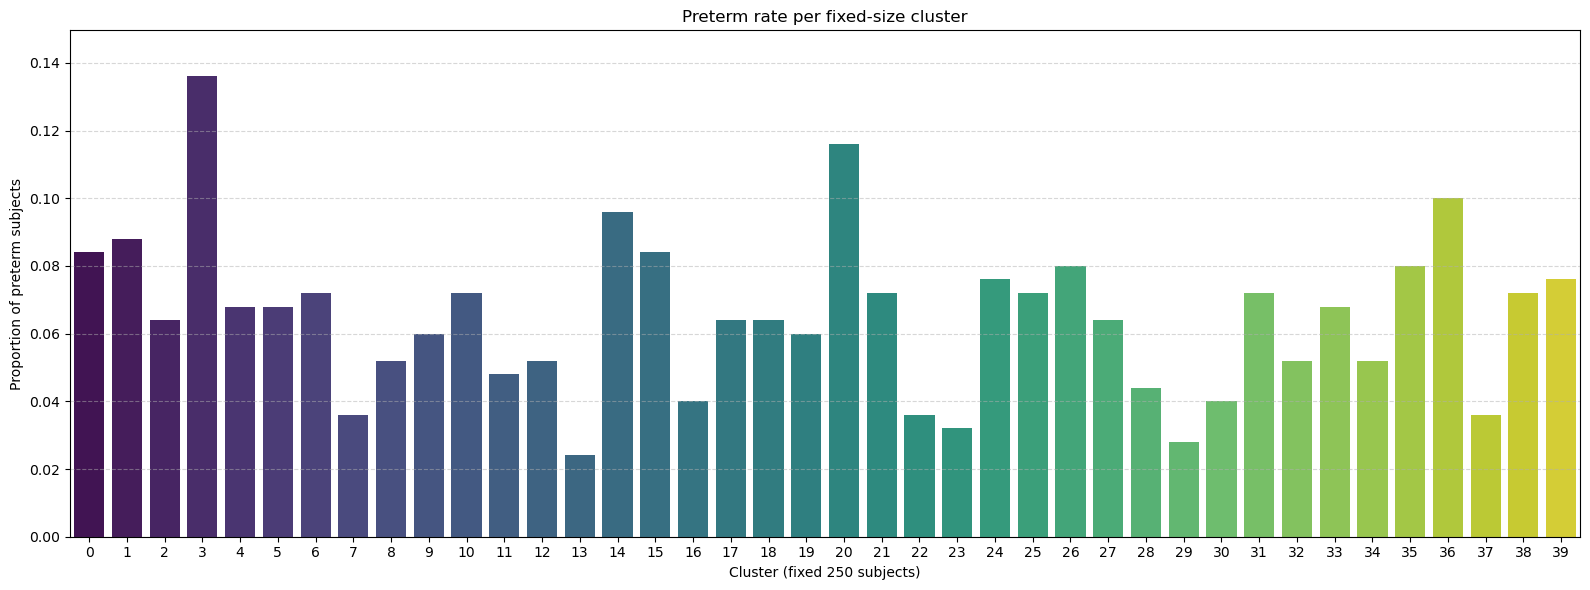

In [65]:
clusters_df = out_df.merge(
    df[['src_subject_id','y']],
    on='src_subject_id',
    how='left'
)

# Compute the stats per cluster
cluster_stats = (
    clusters_df
    .groupby('cluster_fixed250')['y']
    .agg(['count','sum'])                     # count = 250, sum = n_preterms
    .rename(columns={'count':'n_subjects',
                     'sum':'n_preterms'})
)
cluster_stats['preterm_rate'] = (
    cluster_stats['n_preterms'] / cluster_stats['n_subjects']
)

# Quick overview of the stats
for c in cluster_stats.index:
    rate = cluster_stats.loc[c,'preterm_rate']
    print(f"Cluster {c}: {cluster_stats.loc[c,'n_preterms']} preterms / "
          f"{cluster_stats.loc[c,'n_subjects']} ({rate:.2%})")

# Barplot 
plt.figure(figsize=(16,6))
sns.barplot(
    x=cluster_stats.index,
    y=cluster_stats['preterm_rate'],
    palette='viridis'
)
plt.ylabel("Proportion of preterm subjects")
plt.xlabel("Cluster (fixed 250 subjects)")
plt.title("Preterm rate per fixed‑size cluster")
plt.ylim(0, cluster_stats['preterm_rate'].max() * 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [57]:
# Compute prematurity rate per fixed cluster
preterm_rates = (
    clusters_df
    .groupby('cluster_fixed250')['y']
    .mean()
    .sort_values(ascending=False)
)

# Rank clusters by descending prematurity rate
ranked_clusters = {
    cluster_id: rank 
    for rank, cluster_id in enumerate(preterm_rates.index)
}

# Add a new column 'cluster_ranked'
clusters_df['cluster_ranked'] = clusters_df['cluster_fixed250'].map(ranked_clusters)

# Sort DataFrame by that rank (so that cluster 0 is the one with highest preterm rate)
clusters_df = clusters_df.sort_values(by=['cluster_ranked', 'cluster_fixed250'])

# Save to CSV
clusters_df.to_csv("clusters_fixed250_overlapping_ranked_FCMpost-SpC_right.csv", index=False)
